# Importing Libraries

In [1]:
!pip install -q yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Loss

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Layer, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

from sklearn.metrics import confusion_matrix, classification_report

2024-12-11 00:58:57.462488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 00:58:57.462600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 00:58:57.624224: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Defining Functions

In [13]:
def add_target_candlestick(ticker, df):  
    START_DATE = df.index.min().strftime('%Y-%m-%d')
    END_DATE = df.index.max().strftime('%Y-%m-%d')
    target = yf.Ticker(ticker)
    target_history = target.history(start=START_DATE, end=END_DATE)
    target_history.index = target_history.index.normalize()
    
    if target_history.index.tz:
        target_history.index = target_history.index.tz_convert(None)
    else:
        target_history.index = target_history.index.tz_localize(None)

    target_candlestick = target_history[['Open', 'High', 'Low', "Close", 'Volume']]
    target_candlestick.index = pd.to_datetime(target_candlestick.index, format='%Y-%m-%d')
    target_candlestick.index = target_candlestick.index.normalize()
    
    df["Open"] = target_candlestick["Open"]
    df["High"] = target_candlestick["High"]
    df["Low"] = target_candlestick["Low"]
    df["Close"] = target_candlestick["Close"]
    df["Volume"] = target_candlestick["Volume"]    
    df = df.ffill()
    return df



def calculate_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI



def add_technical_indicators(ticker, data):
    data['SMA_50'] = data[f"{ticker}"].rolling(window=50).mean()
    data['SMA_200'] = data[f"{ticker}"].rolling(window=200).mean()
    data['EMA_12'] = data[f"{ticker}"].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data[f"{ticker}"].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']
    data['RSI_14'] = calculate_RSI(data[f"{ticker}"], 12)
    data['SMA_20'] = data[f"{ticker}"].rolling(window=20).mean()
    data['Rolling_STD_20'] = data[f"{ticker}"].rolling(window=20).std()
    data['Bollinger_Upper'] = data['SMA_20'] + (data['Rolling_STD_20'] * 2)
    data['Bollinger_Lower'] = data['SMA_20'] - (data['Rolling_STD_20'] * 2)    
    data['Volatility_30'] = np.log(data[f"{ticker}"] / data[f"{ticker}"].shift(1)).rolling(window=30).std() * np.sqrt(252)
    
    data['H-L'] = data['High'] - data['Low']
    data['H-PC'] = abs(data['High'] - data[f"{ticker}"].shift(1))
    data['L-PC'] = abs(data['Low'] - data[f"{ticker}"].shift(1))
    data['TR'] = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    data['ATR_14'] = data['TR'].rolling(window=14).mean()
    data.drop(['H-L', 'H-PC', 'L-PC', 'TR'], axis=1, inplace=True)
    TP = (data['High'] + data['Low'] + data[f"{ticker}"]) / 3
    data['SMA_TP_20'] = TP.rolling(window=20).mean()
    data['MAD'] = TP.rolling(window=20).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    data['CCI_20'] = (TP - data['SMA_TP_20']) / (0.015 * data['MAD'])
    data.drop(['SMA_TP_20', 'MAD'], axis=1, inplace=True)
    
    data['Rolling_Mean_10'] = data[f"{ticker}"].rolling(window=10).mean()
    data['Rolling_Mean_50'] = data[f"{ticker}"].rolling(window=50).mean()
    data['Rolling_Std_10'] = data[f"{ticker}"].rolling(window=10).std()
    data['Rolling_Std_50'] = data[f"{ticker}"].rolling(window=50).std()
    
    data['Skew_10'] = data[f"{ticker}"].rolling(window=10).skew()
    data['Kurtosis_10'] = data[f"{ticker}"].rolling(window=10).kurt()
    data['Z_Score_10'] = (data[f"{ticker}"] - data['Rolling_Mean_10']) / data['Rolling_Std_10']
    return data



def add_portfolio_stocks(tickers):
    data.index = data.index.normalize()
    START_DATE = data.index.min().strftime('%Y-%m-%d')
    END_DATE = data.index.max().strftime('%Y-%m-%d')
    
    for ticker in tickers:
        prices = yf.Ticker(ticker)
        data_history = prices.history(start=START_DATE, end=END_DATE)
        data_history.index = data_history.index.normalize()
        data_history.index = pd.to_datetime(data_history.index, format='%Y-%m-%d')  
    
        if data_history.index.tz:
            data_history.index = data_history.index.tz_convert(None)
        else:
            data_history.index = data_history.index.tz_localize(None)
            
        data_close = data_history["Close"]
        data_close.index = pd.to_datetime(data_close.index, format='%Y-%m-%d')  
        data_close.index = data_close.index.normalize()
    
        data[f"{ticker}"] = data_close
    return data



def visualise_missing_values(df, drop_from, drop_till):
    df = df.drop(df.loc[drop_from:drop_till].index)
    plt.figure(figsize=(5, 2))
    sns.heatmap(df.isna(), cbar=False, cmap='viridis')
    plt.title('Heatmap of Missing Values')
    return plt.show()


    
def generate_drawdown_labels(prices, period_length, top_k):
    labels = pd.Series(0, index=prices.index)
    num_periods = int(np.ceil(len(prices) / period_length))
    
    for i in range(num_periods):
        start_idx = i * period_length
        end_idx = min((i + 1) * period_length, len(prices))
        window_prices = prices.iloc[start_idx:end_idx]
        window_index = window_prices.index
        cumulative_max = window_prices.cummax()
        drawdowns = (window_prices - cumulative_max) / cumulative_max
        drawdown_df = pd.DataFrame({'Price': window_prices, 'Cumulative_Max': cumulative_max, 'Drawdown': drawdowns}, index=window_index)
        peaks = drawdown_df[drawdown_df['Price'] == drawdown_df['Cumulative_Max']].index
        
        drawdown_info = []
        for j, peak in enumerate(peaks):
            if j < len(peaks) - 1:
                window = drawdown_df.loc[peak:peaks[j+1]] 
            else:
                window = drawdown_df.loc[peak:]
                
            trough = window['Price'].idxmin()
            trough_price = window.loc[trough, 'Price']
            peak_price = window.loc[peak, 'Price']
            drawdown_pct = (trough_price - peak_price) / peak_price
            
            if trough_price < peak_price:
                drawdown_info.append({'Start': peak, 'End': trough, 'Drawdown': drawdown_pct})
        
        drawdown_info_df = pd.DataFrame(drawdown_info)
        if not drawdown_info_df.empty:
            top_drawdowns = drawdown_info_df.nsmallest(top_k, 'Drawdown')
            for _, row in top_drawdowns.iterrows():
                labels.loc[row['Start']:row['End']] = 1  # Set label to 1 for drawdown periods
    return labels



def feature_engineering(split_value=0.8, corr_threshold=0.9, k=None):
    split = int(split_value*len(data))
    train, test = data[:split], data[split:]
    X_train = train.drop("Market_State", axis=1)
    y_train = train["Market_State"]
    X_test = test.drop("Market_State", axis=1)
    y_test = test["Market_State"]
    X_feature = X_train.iloc[:-2,:] # features for predicting next 2 periods
    y_feature = y_train.iloc[2:]
    
    corr_matrix = X_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    X_feature_uncorr = X_feature.drop(high_corr_features, axis=1)

    if k == None:
        k = len(X_feature_uncorr.columns)
    select_k = SelectKBest(score_func=f_regression, k=k)
    X_uni = select_k.fit_transform(X_feature_uncorr, y_feature)
    top_k_features = X_feature_uncorr.columns[select_k.get_support()]
    X_train_top_k = X_train[top_k_features]
    X_test_top_k = X_test[top_k_features]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_top_k.values)
    X_test = scaler.transform(X_test_top_k.values)
    return X_train, X_test, y_train.values, y_test.values



def create_sequences(features, label, seq_length=60):
    X, Y = [], []
    for i in range(len(features) - seq_length - 2):  
        x = features[i : i + seq_length, :]
        y = label[i + seq_length + 2]  
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)



def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred_binary = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred_binary, 'float'), axis=0)
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred_binary), 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred_binary, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred_binary), 'float'), axis=0)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)



class F1Loss(Loss):
    def __init__(self, epsilon=1e-7, name="f1_loss"):
        super().__init__(name=name)
        self.epsilon = epsilon 

    def call(self, y_true, y_pred):
        y_pred = tf.keras.activations.sigmoid(y_pred)
        tp = tf.reduce_sum(y_true * y_pred, axis=0)
        fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
        fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)
        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)
        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1_loss = 1 - tf.reduce_mean(f1)
        return f1_loss



def fit_LSTM(lstm_units=500, dropout_rate=0.5, dense_units=1000, learning_rate=0.0001, weight_decay=0.0005, regularizer_val=0.0005, num_layers =1, activation='tanh', loss="binary_crossentropy", split=0.2):  
    regularizer = l1_l2(l1=regularizer_val, l2=weight_decay)
    input_seq = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
    x = input_seq
    for _ in range(num_layers):
        x = Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizer, recurrent_regularizer=regularizer))(x)
        x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units, return_sequences=False, kernel_regularizer=regularizer, recurrent_regularizer=regularizer))(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation=activation, kernel_regularizer=regularizer)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_seq, outputs=output)
    
    model.compile(loss=loss, optimizer=Adam(learning_rate=learning_rate), metrics=[f1_score])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode="min")
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, min_lr=1e-5)
    class_weights_values = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_seq), y=y_train_seq.flatten())
    class_weights = dict(zip(np.unique(y_train_seq), class_weights_values))
    history = model.fit(X_train_seq, y_train_seq, epochs=1000, validation_split=split, batch_size=128, callbacks=[early_stopping], class_weight=class_weights, shuffle=False, verbose=0)

    fig, axes = plt.subplots(1, 2, figsize = (8,2))
    axes[0].plot(history.history['f1_score'], color="blue")
    axes[0].plot(history.history['val_f1_score'],'--', color="red")
    axes[0].set_title('model accuracy')
    axes[0].set_ylabel('f1 score')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'val'], loc='lower right')
    axes[1].plot(history.history['loss'], color="blue")
    axes[1].plot(history.history['val_loss'],"--", color="red")
    axes[1].set_title('model loss')
    axes[1].set_ylabel('loss')
    axes[1].set_xlabel('epoch')
    plt.show()
    return model



def calculate_metrics(values, rf):
    returns = np.diff(np.log(values))
    annual_return = np.mean(returns)*252
    volatility = np.std(returns)*np.sqrt(252) 
    sharpe_ratio = (annual_return - rf) / volatility
    series = pd.Series(values)
    max_drawdown = (((series - series.cummax()) / series.cummax()).min()) * -100
    return annual_return, volatility, max_drawdown, sharpe_ratio



def model_metrics(X_test, y_actual):
    data_test = data.iloc[-len(y_actual):]
    index = data_test.index
    y_pred_prob = model.predict(X_test)
    y_pred = np.rint(y_pred_prob)
    y_actual = y_actual
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    
    axes[0].plot(index, y_actual, label='Actual', color='blue', linestyle='-', markersize=4)
    axes[0].plot(index, y_pred, label='Predicted', color='red', linestyle='--', markersize=4)
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Market Phase')
    axes[0].set_yticks([0, 1])
    axes[0].set_yticklabels(["Bull", "Drawdown"])
    axes[0].set_title('Actual vs. Predicted Market Phases')
    axes[0].legend(loc="upper right")
    
    conf_matrix = confusion_matrix(y_actual, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=["Bull", "Drawdown"], yticklabels=["Bull", "Drawdown"], ax=axes[1])
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    axes[1].set_title('Confusion Matrix')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    report = classification_report(y_actual, y_pred, target_names=["Bull", "Drawdown"])
    print(report)
    return y_pred

# Downloading Data and Engineering Features

In [4]:
# Load dataset
data = pd.read_csv("/kaggle/input/raw-data-dec-2nd/raw_dataset_dec_2.csv")
data.set_index("Date", inplace=True)
data.index = pd.to_datetime(data.index)
data = data.ffill()

data["S&P_500_Basis"] = data["S&P_500_Close"] - data["S&P ft_Close"]
data["Dow_Jones_Basis"] = data["Dow_Jones_Close"] - data["Dow ft_Close"]
data["NASDAQ_Composite_Basis"] = data["NASDAQ_Composite_Close"] - data["NASDAQ ft_Close"]

tickers = ["SH", "XLP", "XLK"]

data = add_portfolio_stocks(tickers)
data = add_target_candlestick("^GSPC", data)
data = add_technical_indicators("Close", data)
data = data.ffill()
data = data.drop("Date.1", axis=1)

# Data Size Optimisation

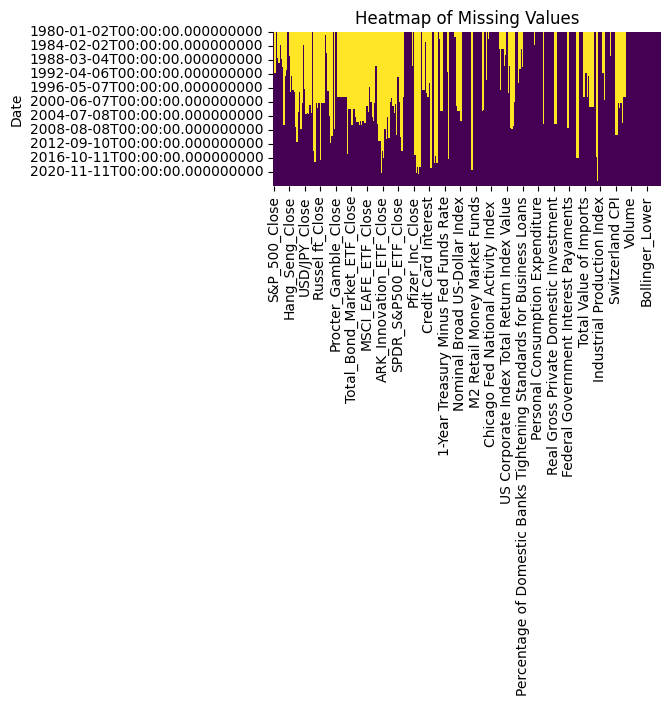

In [5]:
visualise_missing_values(data, data.index[0], "1980-01-01")

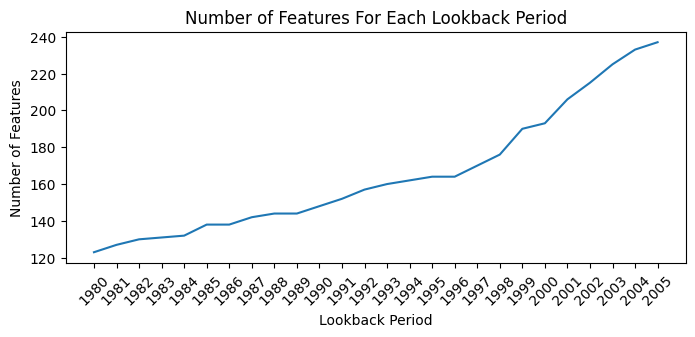

In [6]:
years = [str(y) for y in range(1980, 2006)]
num_of_columns = []

for year in years:
    data_slice = data.drop(data.loc[:f"{year}-01-01"].index)
    data_slice = data_slice.dropna(axis=1, how="any")
    num_of_columns.append(len(data_slice.columns))

plt.figure(figsize=(8,3))
plt.plot(years, num_of_columns)
plt.title("Number of Features For Each Lookback Period")
plt.xlabel("Lookback Period")
plt.xticks(rotation=45)
plt.ylabel("Number of Features")
plt.show()

In [7]:
data_1980 = data.drop(data.loc[:"1980-01-01"].index)
data_1990 = data.drop(data.loc[:"1990-01-01"].index)
data_1996 = data.drop(data.loc[:"1996-01-01"].index)
data_2000 = data.drop(data.loc[:"2000-01-01"].index)
data_2005 = data.drop(data.loc[:"2005-01-01"].index)
data_2008 = data.drop(data.loc[:"2008-06-01"].index)

# Top k Drawdowns (Peak to Trough)

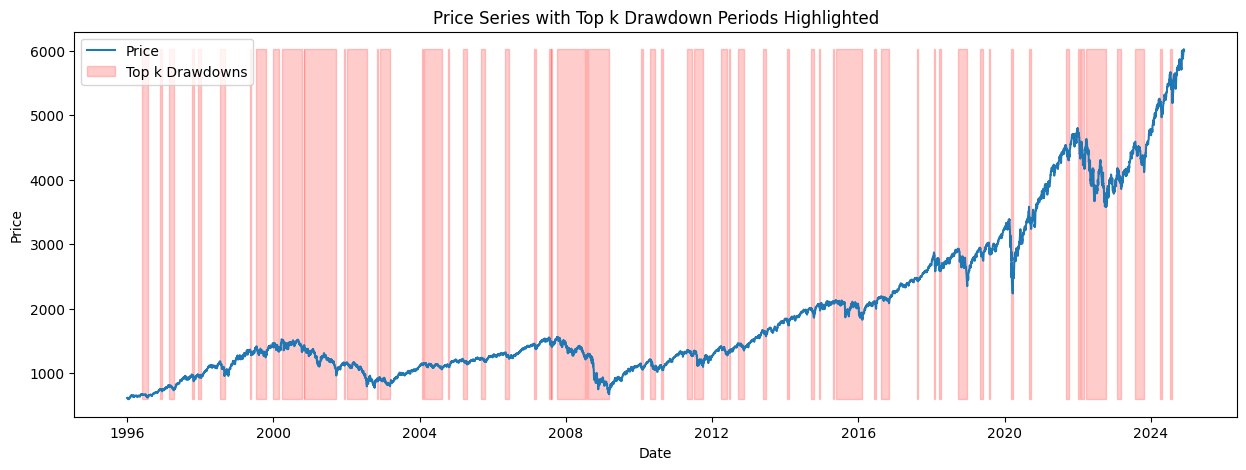

In [8]:
data = data_1996
prices = data["Close"]
period_length = 252
top_k = 2

data["Market_State"] = generate_drawdown_labels(prices, period_length, top_k)

plt.figure(figsize=(15, 5))
plt.plot(prices.index, prices.values, label='Price')

plt.fill_between(
 data.Market_State.index, 
 prices.min(), 
 prices.max(), 
 where=data.Market_State.values == 1, 
 color='red', 
 alpha=0.2, 
 label='Top k Drawdowns')

plt.legend()
plt.title('Price Series with Top k Drawdown Periods Highlighted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

data_for_pf = data.copy()
data = data.dropna(axis=1, how="any")

# Evaluating Profitability of Labels

Risk Free Rate: 2.38%


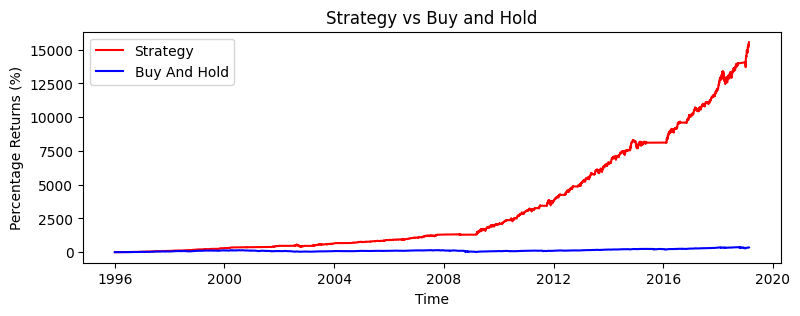

Strategy Profit: 15552.56%
Buy and Hold Profit: 346.73%

Trading Strategy Metrics:
Annual Return: 164.80%
Volatility: 0.21
Maximum Drawdown: 0.11%
Sharpe Ratio: 25.06

Buy and Hold Metrics:
Annual Return: 20.93%
Volatility: 0.06
Maximum Drawdown: 0.19%
Sharpe Ratio: 56.78


In [9]:
split = int(0.8 * len(data_for_pf))
data_test = data_for_pf.iloc[:split]
index = data_test.index

daily_rf = data_test["Federal Funds Rate"]
rf_rate = daily_rf.values
rf_annual = np.mean(rf_rate) / 100
print(f"Risk Free Rate: {rf_annual*100:.2f}%") 

bull_pf_price = data_test["Close"].values
market_price = data_test["Close"].values
market_state = data_test["Market_State"].astype(np.int32).values

initial_balance = 10000
slippage = 0.997
position_size = 1

balance = initial_balance
bull_pf_shares = 0
buy_price = 0
portfolio = []

for i in range(len(market_state) - 1):
    
    if market_state[i] == 0 and bull_pf_shares == 0 and balance > 0:  # Buy Shares
        bull_pf_shares = position_size * balance * slippage / bull_pf_price[i + 1]
        balance -= bull_pf_shares * bull_pf_price[i + 1] / slippage
        buy_price = bull_pf_price[i + 1]
        
    if bull_pf_price[i] / buy_price < 0.98 and bull_pf_shares > 0: # Stop Loss
        balance += bull_pf_shares * bull_pf_price[i + 1] * slippage
        bull_pf_shares = 0
        
    if market_state[i] == 1 and bull_pf_shares > 0:  # Sell Shares
        balance += bull_pf_shares * bull_pf_price[i + 1] * slippage
        bull_pf_shares = 0

    if balance > 0: # Earn Interest on Cash
        balance *= (1 + (rf_rate[i] / 25200))

    portfolio_value = balance + (bull_pf_shares * bull_pf_price[i + 1])
    portfolio.append(portfolio_value)

portofolio = np.array(portfolio)
portfolio_returns = ((portfolio / portfolio[0]) - 1) * 100
market_returns = ((market_price / market_price[0]) - 1) * 100

plt.figure(figsize=(9, 3))
plt.plot(index[:-1], portfolio_returns, label="Strategy", color="red")
plt.plot(index[:-1], market_returns[:-1], label="Buy And Hold", color="blue") 
plt.xlabel('Time')
plt.ylabel('Percentage Returns (%)')
plt.title('Strategy vs Buy and Hold')
plt.legend()
plt.show()    

profit = (portfolio[-1] * 100 / portfolio[0]) - 100
buy_hold_profit = (market_price[-1] * 100 / market_price[1])- 100
print(f"Strategy Profit: {profit:.2f}%")
print(f"Buy and Hold Profit: {buy_hold_profit:.2f}%")

trading_metrics = calculate_metrics(portfolio,rf_annual)
buy_and_hold_metrics = calculate_metrics(bull_pf_price,rf_annual)

print("\nTrading Strategy Metrics:")
print(f"Annual Return: {trading_metrics[3]*100:.2f}%")
print(f"Volatility: {trading_metrics[0]:.2f}")
print(f"Maximum Drawdown: {trading_metrics[1]:.2f}%")
print(f"Sharpe Ratio: {trading_metrics[2]:.2f}")

print("\nBuy and Hold Metrics:")
print(f"Annual Return: {buy_and_hold_metrics[3]*100:.2f}%")
print(f"Volatility: {buy_and_hold_metrics[0]:.2f}")
print(f"Maximum Drawdown: {buy_and_hold_metrics[1]:.2f}%")
print(f"Sharpe Ratio: {buy_and_hold_metrics[2]:.2f}")

# LSTM Predictions

We select features first by eliminating features with a correlation over 0.9. The remaining features are put into a 

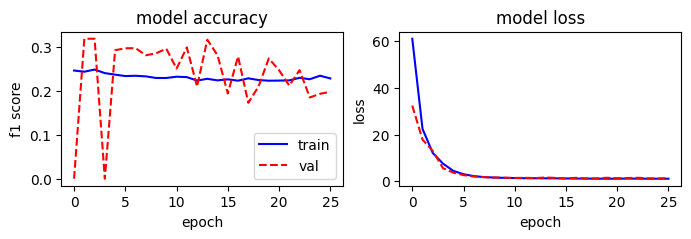

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


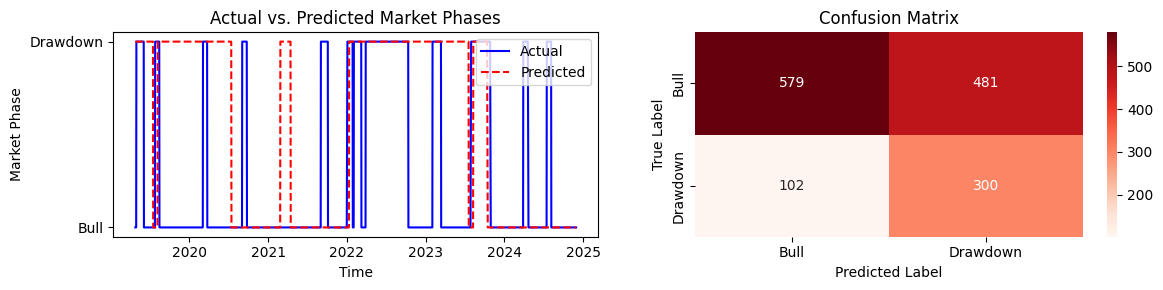

              precision    recall  f1-score   support

        Bull       0.85      0.55      0.67      1060
    Drawdown       0.38      0.75      0.51       402

    accuracy                           0.60      1462
   macro avg       0.62      0.65      0.59      1462
weighted avg       0.72      0.60      0.62      1462



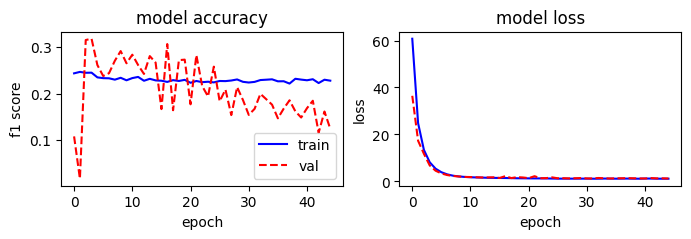

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


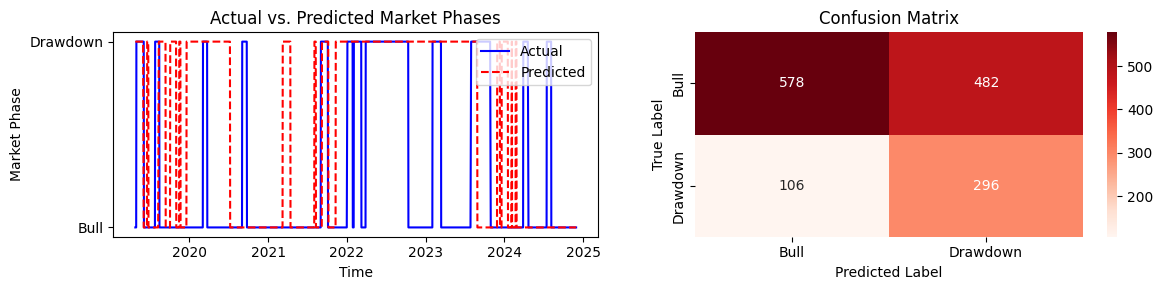

              precision    recall  f1-score   support

        Bull       0.85      0.55      0.66      1060
    Drawdown       0.38      0.74      0.50       402

    accuracy                           0.60      1462
   macro avg       0.61      0.64      0.58      1462
weighted avg       0.72      0.60      0.62      1462



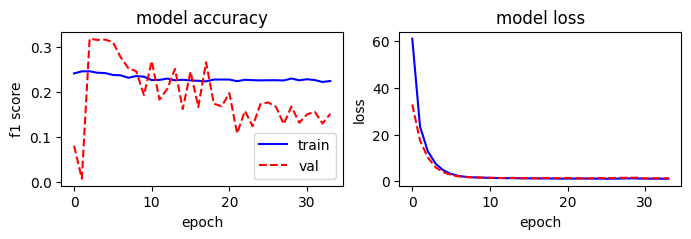

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


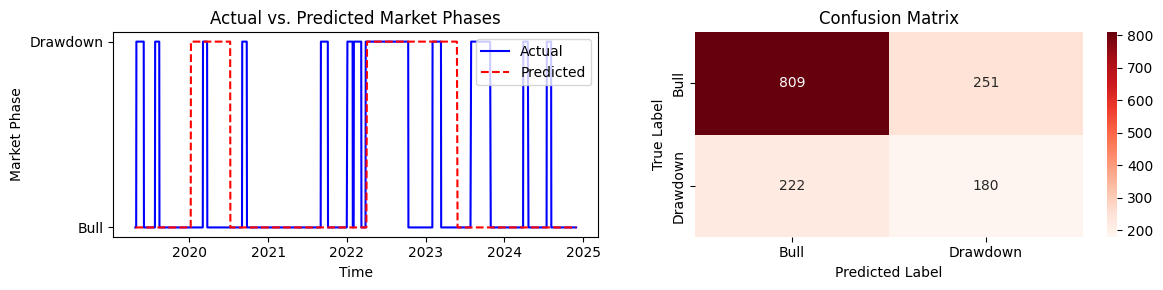

              precision    recall  f1-score   support

        Bull       0.78      0.76      0.77      1060
    Drawdown       0.42      0.45      0.43       402

    accuracy                           0.68      1462
   macro avg       0.60      0.61      0.60      1462
weighted avg       0.68      0.68      0.68      1462



In [17]:
X_train_scaled, X_test_scaled, y_train, y_test = feature_engineering(corr_threshold=0.9)
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, 45)

preds_df = pd.DataFrame()

for i in range(3):
    model = fit_LSTM(
        lstm_units = 500,
        dropout_rate = 0.45,
        dense_units = 1000,
        learning_rate = 0.001,
        weight_decay = 0.0005,
        regularizer_val = 0.0005,
        num_layers = 1,
        activation = 'tanh',
        loss = "binary_crossentropy",
        split = 0.2
                )
    
    X_test, y_actual = create_sequences(X_test_scaled, y_test, 45)
    y_pred = model_metrics(X_test, y_actual)

    preds_df[f"Prediction {i}"] = y_pred.reshape(-1)

# Trading Simulation 1

In this trading simulation we long the S&P 500 when we predict a bull market and hold interest earning cash when a bear market is predicited. We earn daily interest at the Federal Funds rate. The price chosen when going long is the mean price between the days high and low prices. Slippage and transaction costs are set to 0.3% as we are trading a highly liquid asset.

Risk Free Rate: 2.38%


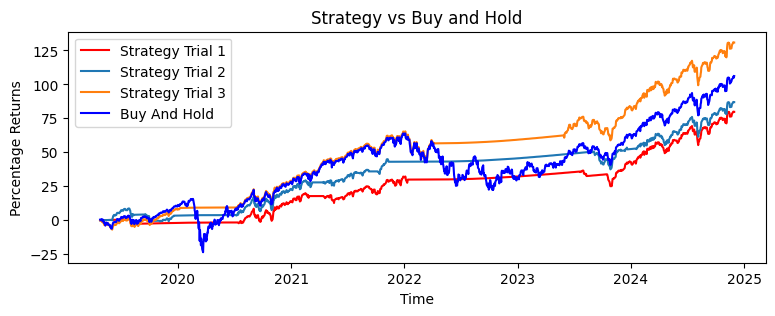


Trading Strategy Metrics:
Annual Return: 11.79%
Volatility: 0.08
Maximum Drawdown: 10.06%
Sharpe Ratio: 1.12

Buy and Hold Metrics:
Annual Return: 12.48%
Volatility: 0.20
Maximum Drawdown: 33.92%
Sharpe Ratio: 0.50


In [21]:
portfolio_returns_df = pd.DataFrame()
portfolio_df = pd.DataFrame()
metrics_df = pd.DataFrame()

data_test = data_for_pf.iloc[-len(y_actual):]
index = data_test[1:].index
market_price = data_test["S&P_500_Close"].values

daily_rf = data_test["Federal Funds Rate"]
rf_rate = daily_rf.values
rf_annual = np.mean(rf_rate) / 100
print(f"Risk Free Rate: {rf_annual*100:.2f}%") 

bull_pf_price = (data_test["High"] + data_test["Low"]) * 0.5
bull_pf_price = bull_pf_price.values
bull_pf_shares = 0

initial_balance = 10000
balance = initial_balance
slippage = 0.997
position_size = 1

for j in range(len(preds_df.columns)):

    market_state = preds_df.iloc[:,j]   
    portfolio_values = []
    
    for i in range(len(y_actual) - 1):
     
        if market_state[i] == 0 and bull_pf_shares == 0 and balance > 0:  # Buy Shares
            bull_pf_shares = position_size * balance * slippage / bull_pf_price[i + 1]
            balance -= bull_pf_shares * bull_pf_price[i + 1] / slippage
            buy_price = bull_pf_price[i + 1]
        
        if bull_pf_price[i] / buy_price < 0.98 and bull_pf_shares > 0: # Stop Loss
            balance += bull_pf_shares * bull_pf_price[i + 1] * slippage
            bull_pf_shares = 0
                
        if market_state[i] == 1 and bull_pf_shares > 0:  # Sell Shares
            balance += bull_pf_shares * bull_pf_price[i + 1] * slippage
            bull_pf_shares = 0
    
        if balance > 0: # Earn Interest on Cash
            balance *= (1 + (rf_rate[i] / 25200))
    
        portfolio_value = balance + (bull_pf_shares * bull_pf_price[i + 1])
        portfolio_values.append(portfolio_value)

    market_returns = ((market_price / market_price[0]) - 1) * 100
    portfolio_returns = ((portfolio_values / portfolio_values[0]) - 1) * 100
    
    portfolio_df[f"Portfolio Value {j}"] = portfolio_values
    portfolio_returns_df[f"Portfolio Return {j}"] = portfolio_returns
    metrics_df[f"metrics {j}"] = calculate_metrics(np.array(portfolio_values),rf_annual)

plt.figure(figsize=(9, 3))
plt.plot(index, portfolio_returns_df.iloc[:,0], label="Strategy Trial 1", color="red")
plt.plot(index, portfolio_returns_df.iloc[:,1], label="Strategy Trial 2")
plt.plot(index, portfolio_returns_df.iloc[:,2], label="Strategy Trial 3")
plt.plot(index, market_returns[1:], label="Buy And Hold", color="blue") 
plt.xlabel('Time')
plt.ylabel('Percentage Returns')
plt.title('Strategy vs Buy and Hold')
plt.legend()
plt.show()

averages = metrics_df.mean(axis=1)
print("\nTrading Strategy Metrics:")
print(f"Annual Return: {averages[0]*100:.2f}%")
print(f"Volatility: {averages[1]:.2f}")
print(f"Maximum Drawdown: {averages[2]:.2f}%")
print(f"Sharpe Ratio: {averages[3]:.2f}")

buy_and_hold_metrics = calculate_metrics(market_price,rf_annual)
print("\nBuy and Hold Metrics:")
print(f"Annual Return: {buy_and_hold_metrics[0]*100:.2f}%")
print(f"Volatility: {buy_and_hold_metrics[1]:.2f}")
print(f"Maximum Drawdown: {buy_and_hold_metrics[2]:.2f}%")
print(f"Sharpe Ratio: {buy_and_hold_metrics[3]:.2f}")

# Trading Simulation 2

In this trading simulation we long the S&P 500 when we predict a bull market and short the S&P 500 when a bear market is predicited. The price chosen when going long is the mean price between the days high and low prices. Slippage and transaction costs are set to 0.3% as we are trading a highly liquid asset.

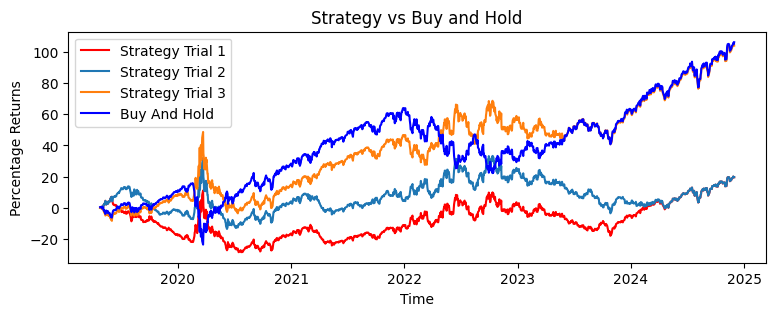


Trading Strategy Metrics:
Annual Return: 6.16%
Volatility: 0.20
Maximum Drawdown: 35.06%
Sharpe Ratio: 0.19

Buy and Hold Metrics:
Annual Return: 12.48%
Volatility: 0.20
Maximum Drawdown: 33.92%
Sharpe Ratio: 0.50


In [19]:
portfolio_returns_df = pd.DataFrame()
portfolio_df = pd.DataFrame()
metrics_df = pd.DataFrame()

bull_pf_price = data_test["Close"].values
bear_pf_price = data_test["SH"].values

bear_pf_shares = 0
bull_pf_shares = 0
bull_buy_price = 0.000001
bear_buy_price = 0.000001

initial_balance = 10000
balance = initial_balance

slippage = 0.997
bull_leverage = 1
bear_leverage = 1
portfolio = []

for j in range(len(preds_df.columns)):

    market_state = preds_df.iloc[:,j]   
    portfolio_values = []
    
    for i in range(len(y_actual) - 1):
        if bull_pf_price[i] / bull_buy_price < 0.98 and bull_pf_shares > 0: # Stop Loss
            balance += bull_pf_shares * bull_pf_price[i + 1] * slippage
            bull_pf_shares = 0
    
        if bear_pf_price[i] / bear_buy_price < 0.98 and bear_pf_shares > 0:
            balance += bear_pf_shares * bear_pf_price[i + 1] * slippage
            bear_pf_shares = 0
        
        if market_state[i] == 0:  # Bull Market
            if bear_pf_shares > 0:
                balance += bear_pf_shares * bear_pf_price[i + 1] * slippage
                bear_pf_shares = 0
                
            # Buy bull shares if not already holding
            if bull_pf_shares == 0 and balance > 0:
                bull_pf_shares = bull_leverage * balance * slippage / bull_pf_price[i + 1]
                balance -= bull_pf_shares * bull_pf_price[i + 1] / slippage
                bull_buy_price = bull_pf_price[i + 1]
    
        elif market_state[i] == 1:  # Bear Market
            if bull_pf_shares > 0:
                balance += bull_pf_shares * bull_pf_price[i + 1] * slippage
                bull_pf_shares = 0
            
            if bear_pf_shares == 0 and balance > 0:
                bear_pf_shares = bear_leverage * balance * slippage / bear_pf_price[i + 1]
                balance -= bear_pf_shares * bear_pf_price[i + 1] / slippage
                bear_buy_price = bear_pf_price[i + 1]
    
        portfolio_value = balance + (bear_pf_shares * bear_pf_price[i + 1]) + (bull_pf_shares * bull_pf_price[i + 1])
        portfolio_values.append(portfolio_value)

    market_returns = ((market_price / market_price[0]) - 1) * 100
    portfolio_returns = ((portfolio_values / portfolio_values[0]) - 1) * 100
    
    portfolio_df[f"Portfolio Value {j}"] = portfolio_values
    portfolio_returns_df[f"Portfolio Return {j}"] = portfolio_returns
    metrics_df[f"metrics {j}"] = calculate_metrics(np.array(portfolio_values),rf_annual)

plt.figure(figsize=(9, 3))
plt.plot(index, portfolio_returns_df.iloc[:,0], label="Strategy Trial 1", color="red")
plt.plot(index, portfolio_returns_df.iloc[:,1], label="Strategy Trial 2")
plt.plot(index, portfolio_returns_df.iloc[:,2], label="Strategy Trial 3")
plt.plot(index, market_returns[1:], label="Buy And Hold", color="blue") 
plt.xlabel('Time')
plt.ylabel('Percentage Returns')
plt.title('Strategy vs Buy and Hold')
plt.legend()
plt.show()

averages = metrics_df.mean(axis=1)
print("\nTrading Strategy Metrics:")
print(f"Annual Return: {averages[0]*100:.2f}%")
print(f"Volatility: {averages[1]:.2f}")
print(f"Maximum Drawdown: {averages[2]:.2f}%")
print(f"Sharpe Ratio: {averages[3]:.2f}")

print("\nBuy and Hold Metrics:")
print(f"Annual Return: {buy_and_hold_metrics[0]*100:.2f}%")
print(f"Volatility: {buy_and_hold_metrics[1]:.2f}")
print(f"Maximum Drawdown: {buy_and_hold_metrics[2]:.2f}%")
print(f"Sharpe Ratio: {buy_and_hold_metrics[3]:.2f}")

# Trading Simulation 2

In this trading simulation we long the Technology Select Sector SPDR Fund which when we predict a bull market and short the Consumer Staples Select Sector SPDR Fund when a bear market is predicited. The closing prices for our bear and bull portfolios are used for trading. Slippage and transaction costs are set to 0.3% as we are trading highly liquid assets.

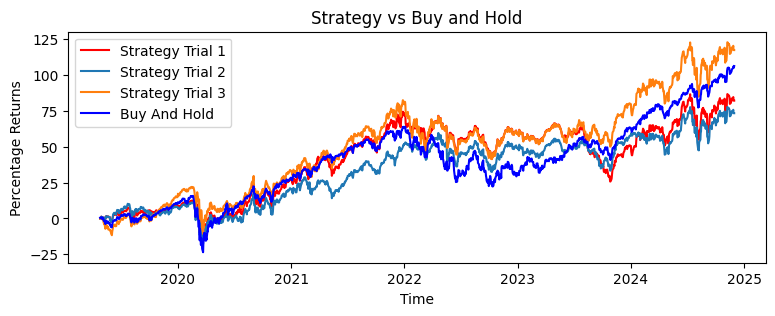


Trading Strategy Metrics:
Annual Return: 11.07%
Volatility: 0.21
Maximum Drawdown: 26.84%
Sharpe Ratio: 0.42

Buy and Hold Metrics:
Annual Return: 12.48%
Volatility: 0.20
Maximum Drawdown: 33.92%
Sharpe Ratio: 0.50


In [20]:
portfolio_returns_df = pd.DataFrame()
portfolio_df = pd.DataFrame()
metrics_df = pd.DataFrame()

bull_pf_price = data_test["XLK"].values
bear_pf_price = data_test["XLP"].values

bear_pf_shares = 0
bull_pf_shares = 0
bull_buy_price = 0.000001
bear_buy_price = 0.000001

initial_balance = 10000
balance = initial_balance

slippage = 0.997
bull_leverage = 1
bear_leverage = 1
portfolio = []

for j in range(len(preds_df.columns)):

    market_state = preds_df.iloc[:,j]   
    portfolio_values = []
    
    for i in range(len(y_actual) - 1):
        if bull_pf_price[i] / bull_buy_price < 0.98 and bull_pf_shares > 0: # Stop Loss
            balance += bull_pf_shares * bull_pf_price[i + 1] * slippage
            bull_pf_shares = 0
    
        if bear_pf_price[i] / bear_buy_price < 0.98 and bear_pf_shares > 0:
            balance += bear_pf_shares * bear_pf_price[i + 1] * slippage
            bear_pf_shares = 0
        
        if market_state[i] == 0:  # Bull Market
            if bear_pf_shares > 0:
                balance += bear_pf_shares * bear_pf_price[i + 1] * slippage
                bear_pf_shares = 0
                
            # Buy bull shares if not already holding
            if bull_pf_shares == 0 and balance > 0:
                bull_pf_shares = bull_leverage * balance * slippage / bull_pf_price[i + 1]
                balance -= bull_pf_shares * bull_pf_price[i + 1] / slippage
                bull_buy_price = bull_pf_price[i + 1]
    
        elif market_state[i] == 1:  # Bear Market
            if bull_pf_shares > 0:
                balance += bull_pf_shares * bull_pf_price[i + 1] * slippage
                bull_pf_shares = 0
            
            if bear_pf_shares == 0 and balance > 0:
                bear_pf_shares = bear_leverage * balance * slippage / bear_pf_price[i + 1]
                balance -= bear_pf_shares * bear_pf_price[i + 1] / slippage
                bear_buy_price = bear_pf_price[i + 1]
    
        portfolio_value = balance + (bear_pf_shares * bear_pf_price[i + 1]) + (bull_pf_shares * bull_pf_price[i + 1])
        portfolio_values.append(portfolio_value)
    
    market_returns = ((market_price / market_price[0]) - 1) * 100
    portfolio_returns = ((portfolio_values / portfolio_values[0]) - 1) * 100
    
    portfolio_df[f"Portfolio Value {j}"] = portfolio_values
    portfolio_returns_df[f"Portfolio Return {j}"] = portfolio_returns
    metrics_df[f"metrics {j}"] = calculate_metrics(np.array(portfolio_values),rf_annual)

plt.figure(figsize=(9, 3))
plt.plot(index, portfolio_returns_df.iloc[:,0], label="Strategy Trial 1", color="red")
plt.plot(index, portfolio_returns_df.iloc[:,1], label="Strategy Trial 2")
plt.plot(index, portfolio_returns_df.iloc[:,2], label="Strategy Trial 3")
plt.plot(index, market_returns[1:], label="Buy And Hold", color="blue") 
plt.xlabel('Time')
plt.ylabel('Percentage Returns')
plt.title('Strategy vs Buy and Hold')
plt.legend()
plt.show()

averages = metrics_df.mean(axis=1)
print("\nTrading Strategy Metrics:")
print(f"Annual Return: {averages[0]*100:.2f}%")
print(f"Volatility: {averages[1]:.2f}")
print(f"Maximum Drawdown: {averages[2]:.2f}%")
print(f"Sharpe Ratio: {averages[3]:.2f}")

buy_and_hold_metrics = calculate_metrics(market_price,rf_annual)
print("\nBuy and Hold Metrics:")
print(f"Annual Return: {buy_and_hold_metrics[0]*100:.2f}%")
print(f"Volatility: {buy_and_hold_metrics[1]:.2f}")
print(f"Maximum Drawdown: {buy_and_hold_metrics[2]:.2f}%")
print(f"Sharpe Ratio: {buy_and_hold_metrics[3]:.2f}")